In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import re
import json
from pathlib import Path

import pandas as pd
import numpy as np

In [2]:
data_dir = Path("../data/apj-rest-ctlg/")

### インスタンスが独立に動作していると考え，インスタンスごと(=hostごと)にDataFrameを作成

In [3]:
instance_num = 3

instance_dict = {i: {} for i in range(1, instance_num + 1)}
json_paths = data_dir.glob("*.json")
for path in json_paths:
    with open(path, "r") as f:
        metric = path.name[:-24]
        results = json.load(f)["results"]
        metric_set = set()
        for src_data in results:
            for data in src_data["data"]:
                metric_set.add(data["metric"])
        for src_data in results:
            if src_data["source"][:10] != "summarizer":
                for data in src_data["data"]:
                    instance_id = int(re.search('\d', data["tags"]["host"]).group())
                    # jsonのキーは順番保証されていないので念の為ソート
                    tags = [data["tags"][key] for key in sorted(data["tags"].keys()) if key != "host"]
                    key_name = metric
                    # metricフィールドが全て同じならキー名に含めない
                    if len(metric_set) > 1:
                        # metricフィールドの冗長な名前を簡潔化
                        metric_attr = re.findall('^.*\.(.*)$', data['metric'])[0]
                        key_name += f"-{metric_attr}"
                    if len(tags) > 0:
                        key_name += f"-{'-'.join(tags)}"
                    instance_dict[instance_id][key_name] = data["NumericType"]

df_dict = {}
for id, instance in instance_dict.items():
    df = pd.DataFrame(instance, dtype="float32")
    df.dropna(inplace=True)
    df = df.loc[:, df.nunique() != 1] # 値が一定のメトリックを除く
    df_dict[id - 1] = df

In [4]:
df = df_dict[0]
df

,avg_cpu-usage_idle,avg_cpu-usage_softirq,avg_cpu-usage_system,avg_cpu-usage_iowait,avg_cpu-usage_user,avg_cpu-usage_steal,avg_cpu-usage_nice,avg_disk_busy-vdb,avg_disk_busy-vda2,avg_disk_iops-writes-vda2,...,avg_query_commands-delete,avg_query_commands-update,avg_query_commands-insert,avg_query_commands-replace,avg_slow_query,avg_threads_connected-mysql_global_status_threads_connected,avg_threads_connected-mysql_global_status_threads_running,disk_usage_(data_volume)___binlog_file_total_size-used-vdb,disk_usage_(percent)-vdb,disk_usage_(percent)-vda2
1,75.296326,0.644787,3.727024,1.127953,18.922928,0.280986,0.0,42.107677,0.078373,7.067408,...,0.0,0.024000,0.099704,0.000148,3.395555,428.799988,6.200000,1.239686e+11,24.056004,63.846325
2,75.277222,0.631469,3.803032,1.315388,18.584949,0.387939,0.0,24.254351,0.072396,6.919703,...,0.0,0.023556,0.102222,0.000000,0.848889,432.200012,6.733333,1.239731e+11,24.056877,63.843327
3,72.333557,0.628650,3.761904,1.539687,21.408892,0.327311,0.0,39.016068,0.103222,7.108889,...,0.0,0.116222,55.741924,0.001111,4.906667,438.066681,7.666667,1.240053e+11,24.063133,63.772366
4,58.018967,1.113455,6.269941,2.191752,32.143456,0.262430,0.0,36.165394,0.174640,6.490148,...,0.0,0.029333,133.107407,0.020296,9.840000,475.000000,12.400000,1.240394e+11,24.069744,63.617744
5,68.899712,0.791235,4.465419,1.470008,24.096800,0.276824,0.0,43.798439,0.144253,5.320074,...,0.0,0.023704,213.066513,0.095481,13.604445,464.533325,11.266666,1.241318e+11,24.087679,63.614513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,68.081329,0.901782,5.182308,1.467767,23.861513,0.505302,0.0,27.408276,0.063520,6.533629,...,0.0,0.041333,0.212148,0.000148,0.991111,434.399994,4.466667,1.217528e+11,23.626045,63.744408
91,78.641289,0.495391,2.865484,1.107001,16.637711,0.253124,0.0,37.061493,0.065893,6.539333,...,0.0,0.095481,0.123778,0.000000,2.426667,421.933319,4.933333,1.217350e+11,23.622583,63.769024
92,65.669083,0.981186,5.716619,2.097001,25.378613,0.157500,0.0,30.012800,0.064853,6.817926,...,0.0,0.041185,0.094963,0.000000,2.688889,446.600006,7.733333,1.217708e+11,23.629536,63.803661
93,73.785278,0.665822,3.864101,1.197935,20.262447,0.224418,0.0,40.750797,0.067880,6.847481,...,0.0,0.035407,0.104444,0.000000,3.431111,431.466675,6.866667,1.217709e+11,23.629545,63.807854


In [5]:
df.filter(like="irq")

,avg_cpu-usage_softirq
1,0.644787
2,0.631469
3,0.628650
4,1.113455
5,0.791235
...,...
90,0.901782
91,0.495391
92,0.981186
93,0.665822


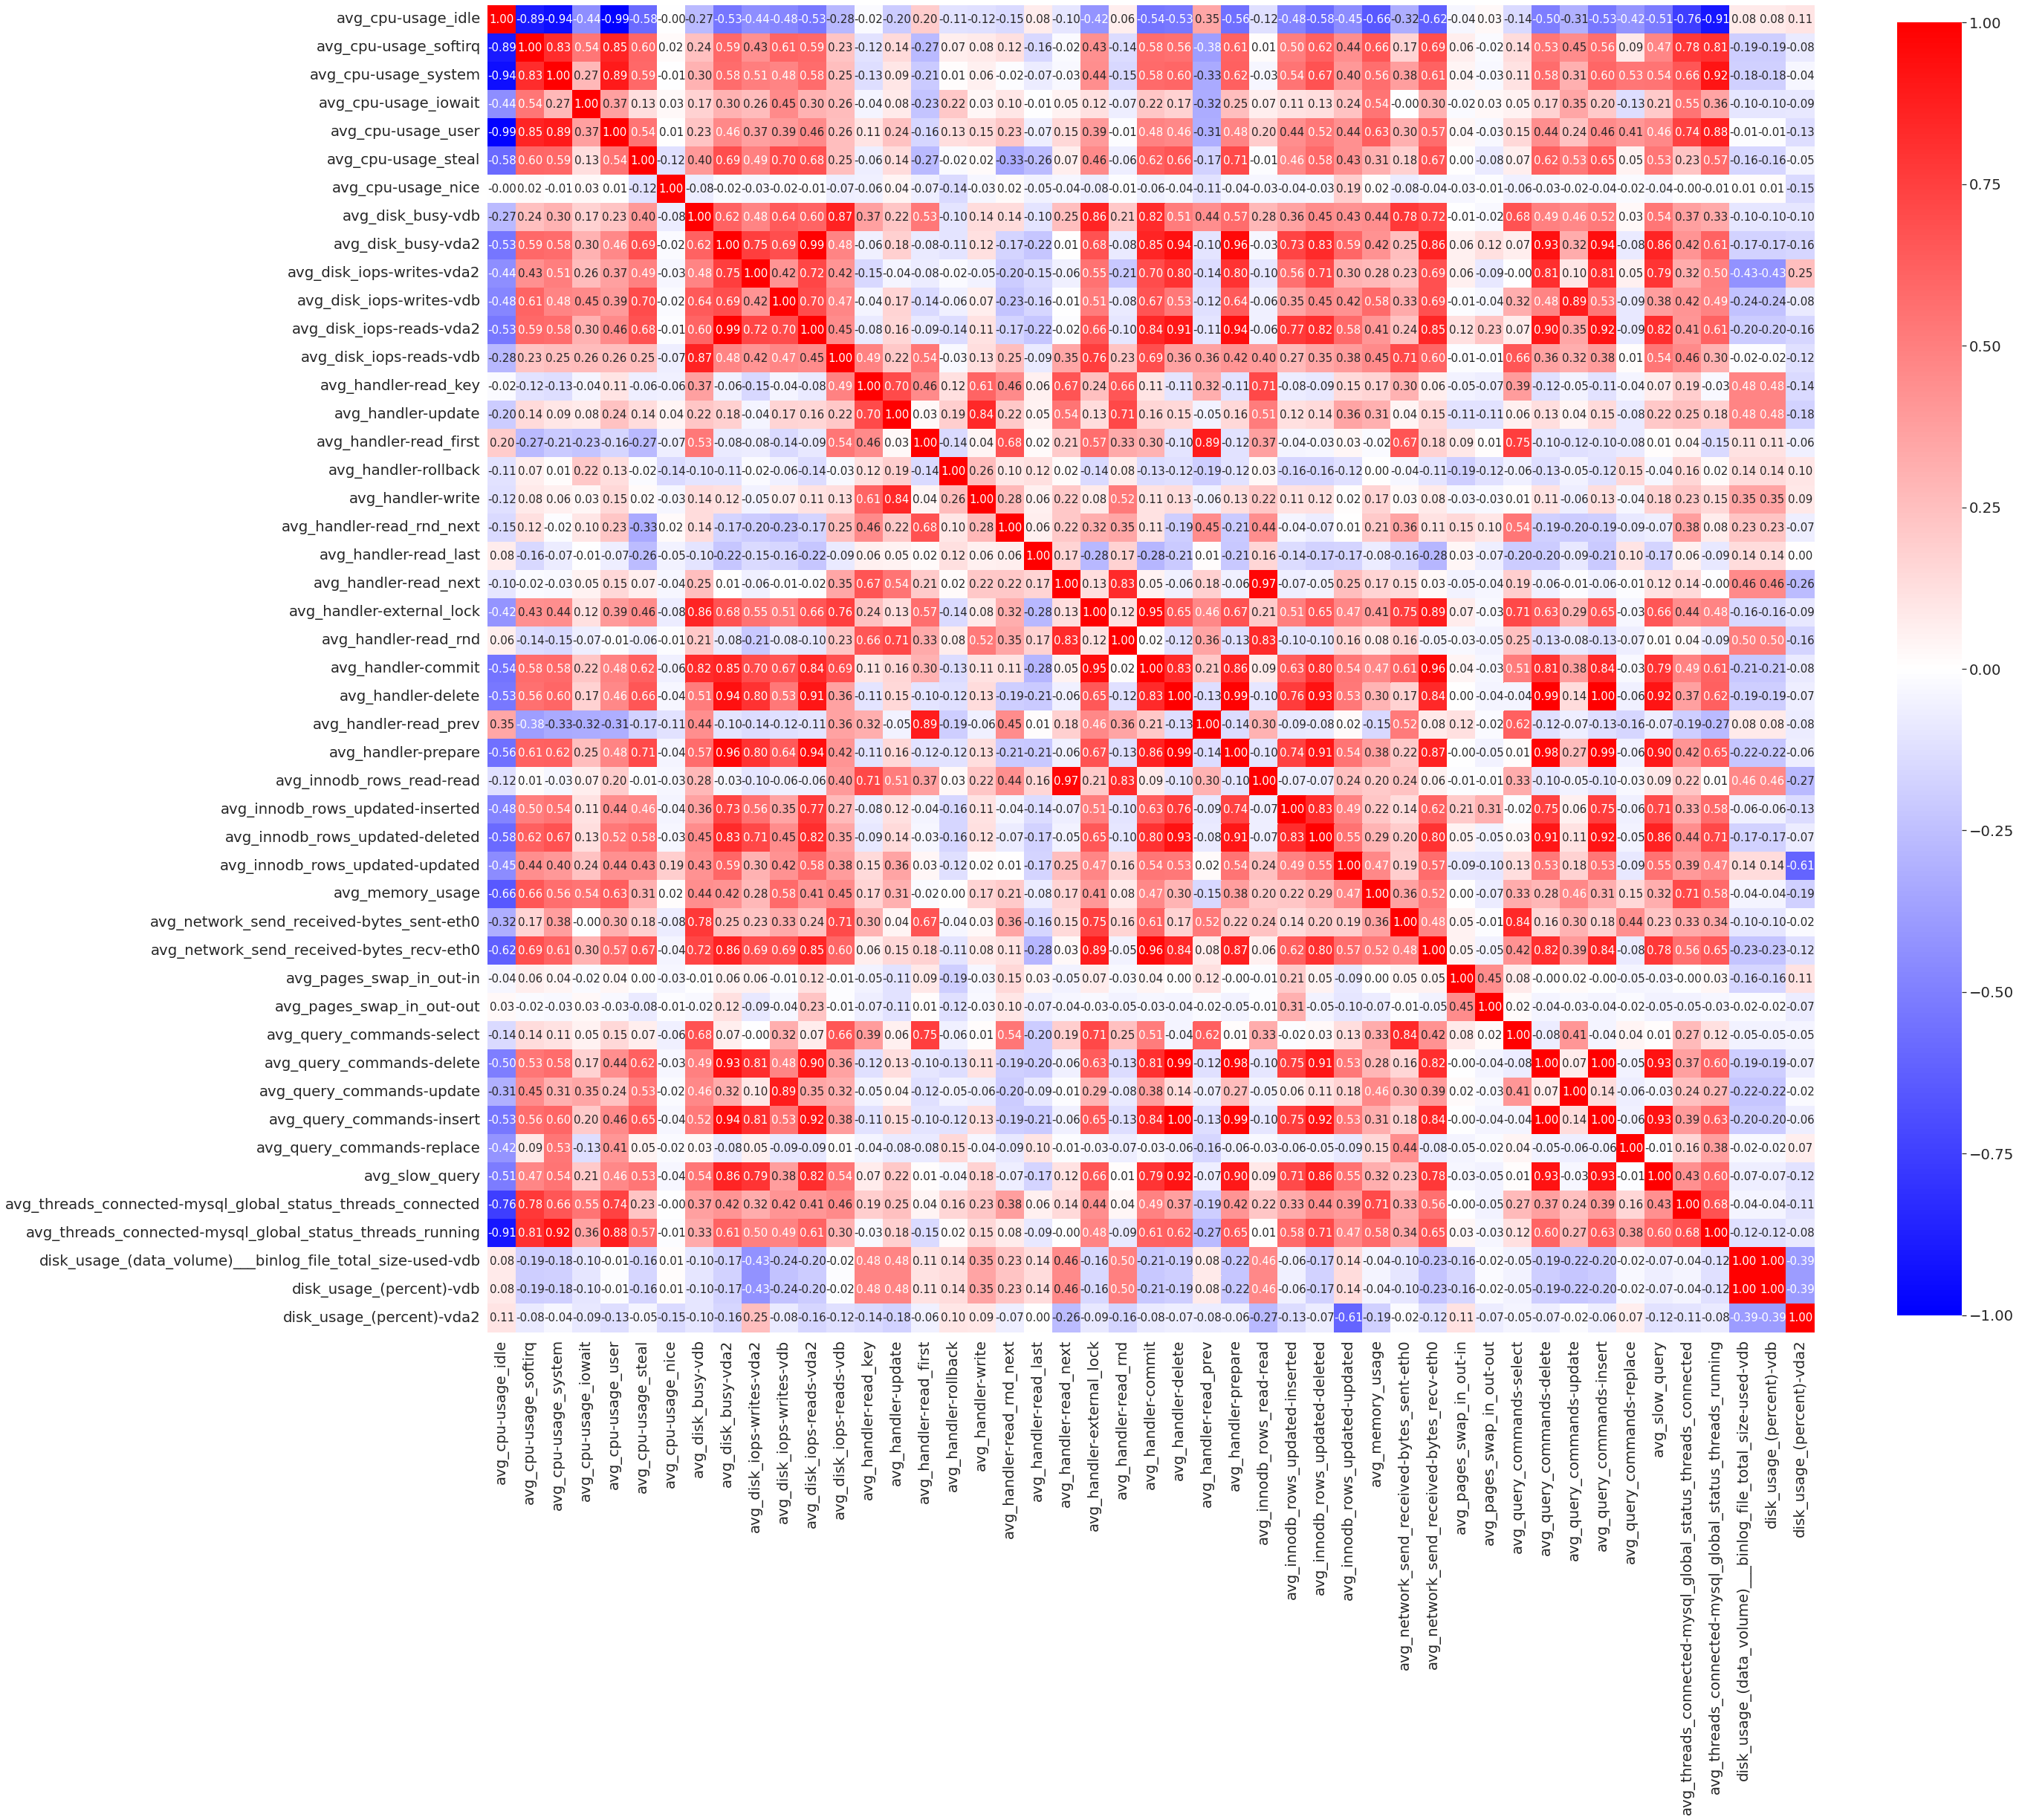

In [5]:
# 値が一定のメトリックを除いて分析
df = df_dict[0]
df = df.loc[:, df.nunique() != 1]

sns.set(font_scale=1.8)
plt.figure(figsize=(40, 40))
sns.heatmap(df.corr(), vmax=1, vmin=-1, center=0, annot=True, square=True, cmap="bwr", annot_kws={"size": 15}, cbar_kws={"shrink": 0.8}, fmt=".2f")
plt.show()

In [6]:
from pprint import pprint

In [7]:
df_corr = df.corr()
corr_mat = df_corr.to_numpy()
cols = df_corr.columns

th = 0.85
del_num = 20

# 相関が th 以上 or -th 以下のメトリックを取り出す
high_corrs_dict = {k: set() for k in cols}
for i, j in zip(*np.where((corr_mat >= th) | (corr_mat <= -th))):
    if i < j:
        # queryはworkloadを最もよく表しているので，消さないようにする
        if cols[i][:9] != "avg_query":
            high_corrs_dict[cols[i]].add(cols[j])
        if cols[j][:9] != "avg_query":
            high_corrs_dict[cols[j]].add(cols[i])

# pprint(sorted(high_corr_dict.items(), key=lambda x: len(x[1]), reverse=True))
del_metrics = []
for _ in range(del_num):
    # 相関が高いメトリック間の関係数をメトリック別に列挙
    # （メトリックごとの関係数を相関係数の和で代用してもいい）
    del_metric = max(high_corrs_dict.items(), key=lambda item: len(item[1]))[0]
    if len(high_corrs_dict[del_metric]) == 0:
        break
    high_corrs_dict.pop(del_metric, None) # キーを削除
    for k, v_set in high_corrs_dict.items():
        if del_metric in v_set:
            v_set.discard(del_metric)
    del_metrics.append(del_metric)
pprint(del_metrics)

['avg_handler-prepare',
 'avg_disk_busy-vda2',
 'avg_handler-delete',
 'avg_cpu-usage_idle',
 'avg_cpu-usage_user',
 'avg_handler-external_lock',
 'avg_innodb_rows_updated-deleted',
 'avg_disk_iops-reads-vda2',
 'avg_slow_query',
 'avg_cpu-usage_system',
 'avg_disk_busy-vdb',
 'avg_disk_iops-writes-vdb',
 'avg_handler-read_first',
 'avg_handler-read_next',
 'avg_handler-commit',
 'disk_usage_(data_volume)___binlog_file_total_size-used-vdb']


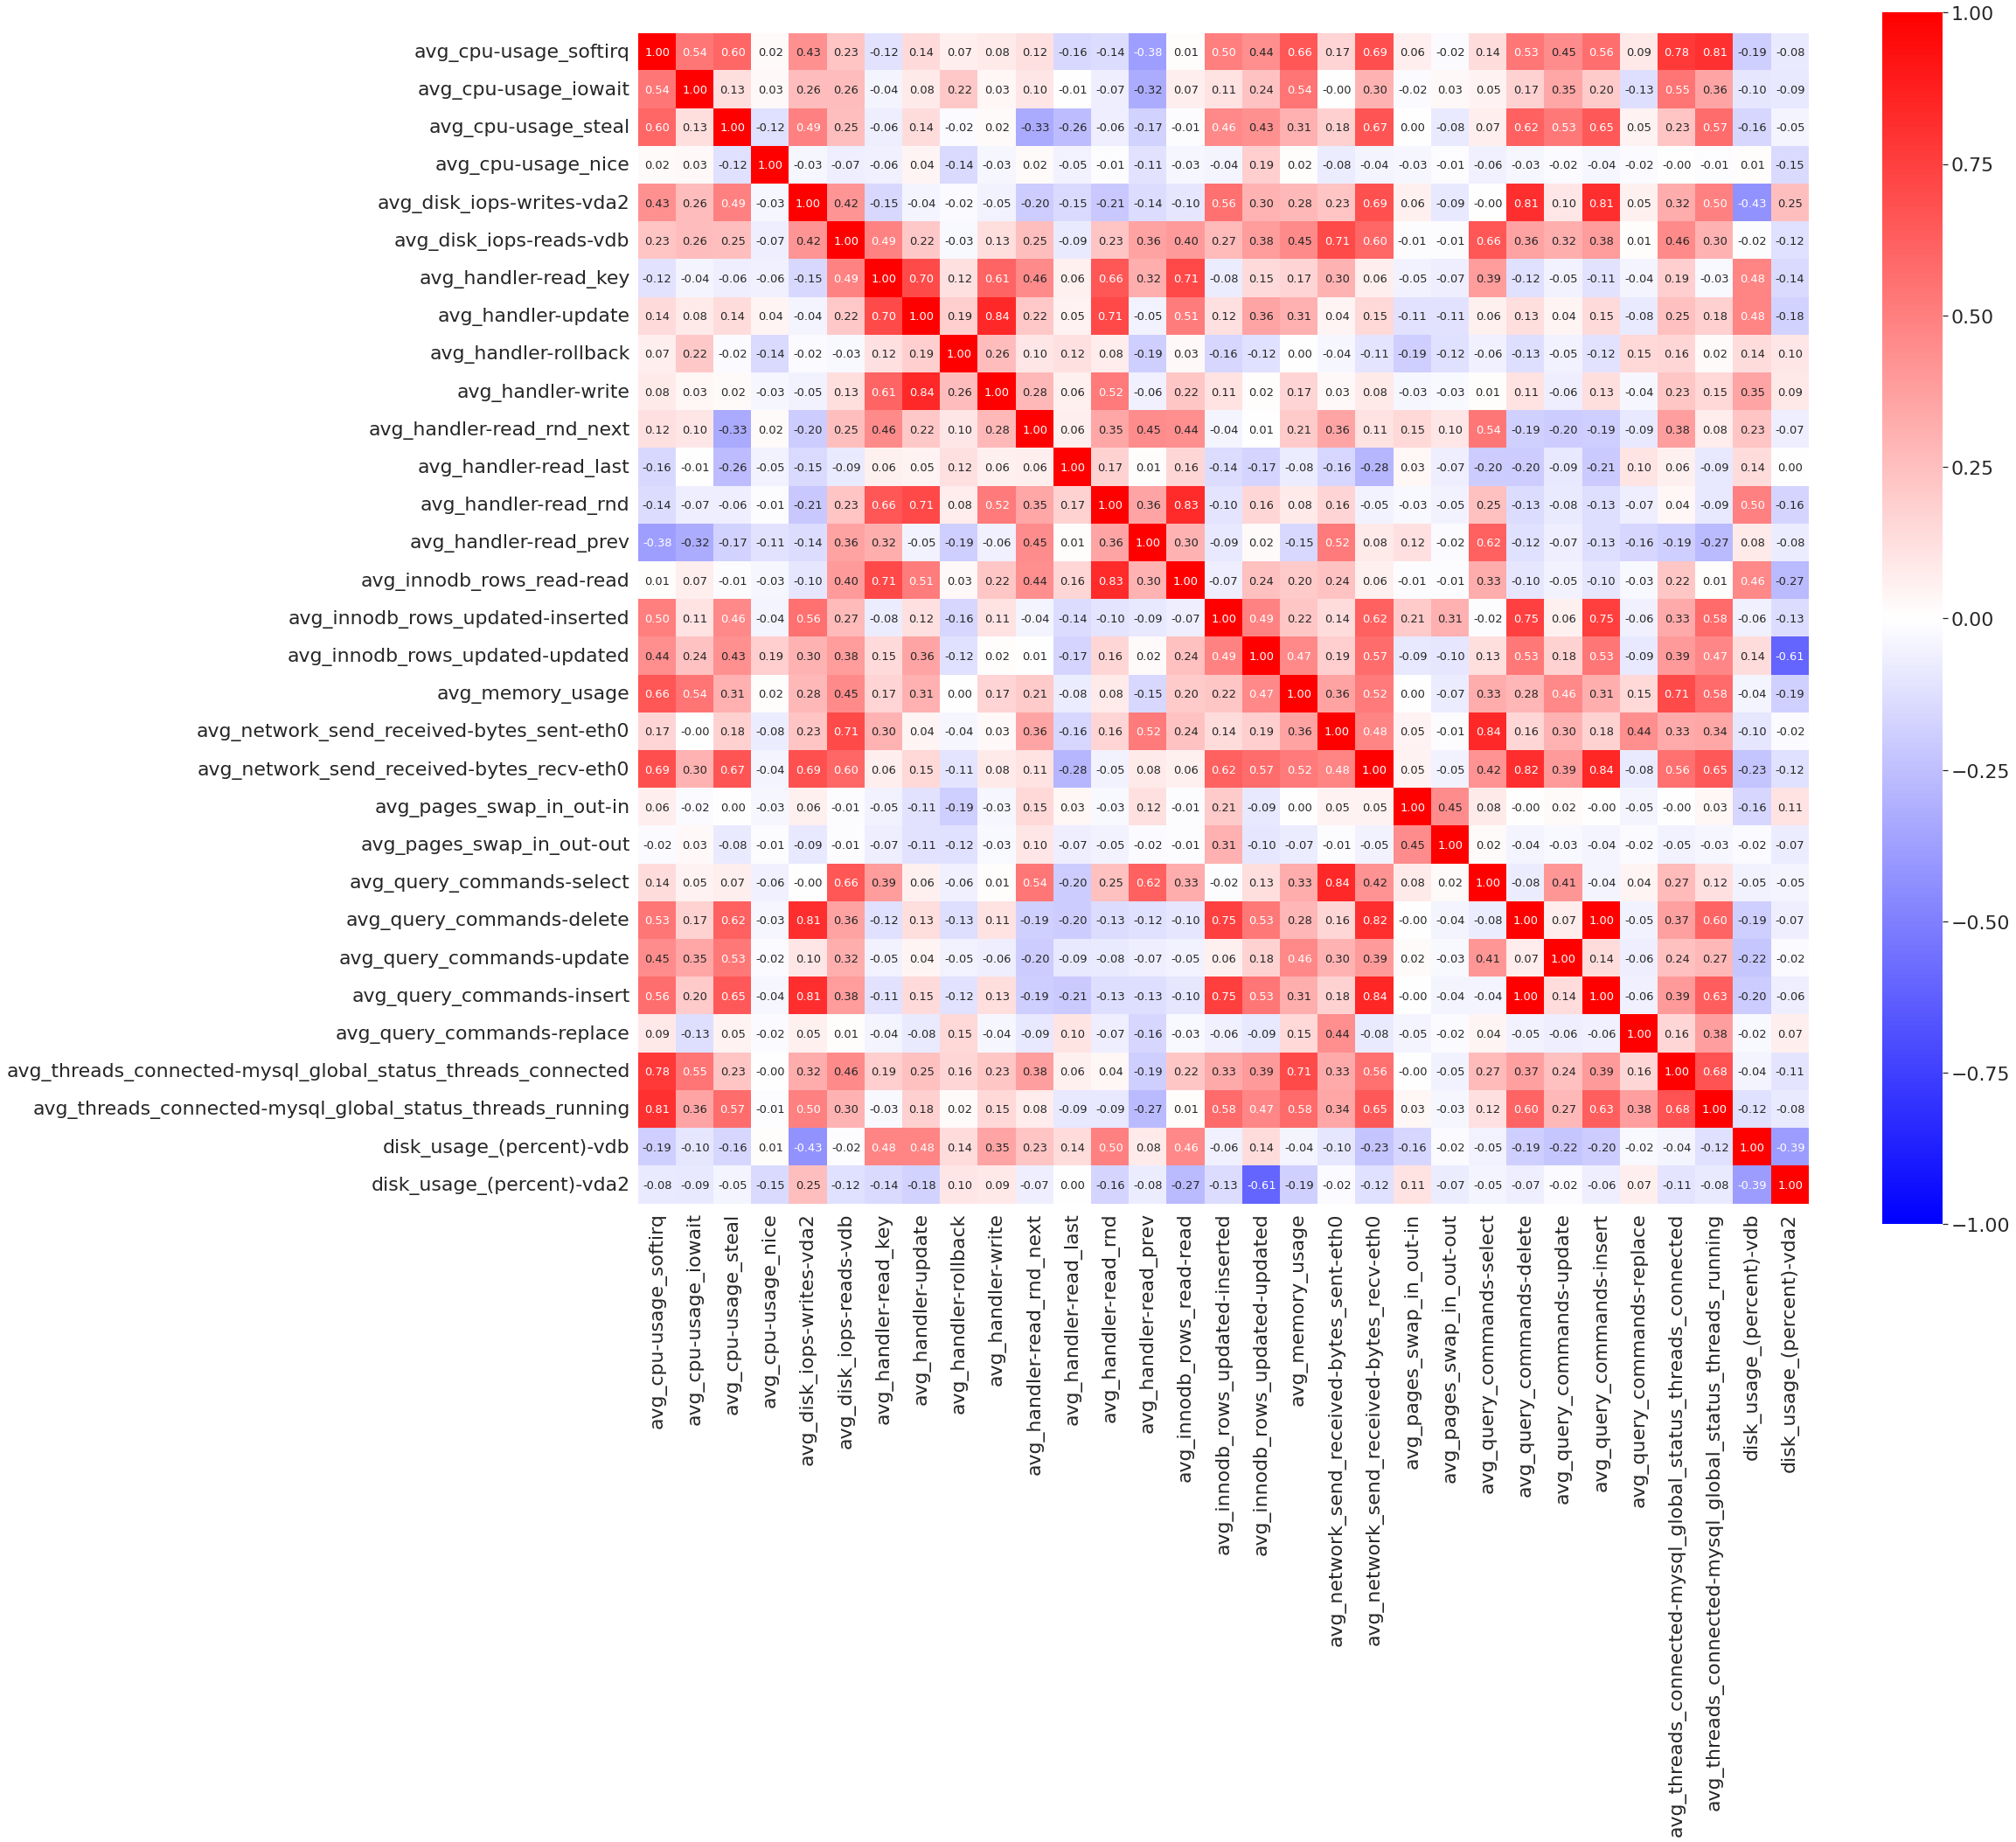

In [8]:
df_selected = df.drop(del_metrics, axis=1)
sns.set(font_scale=2)
plt.figure(figsize=(30, 30))
sns.heatmap(df_selected.corr(), vmax=1, vmin=-1, center=0, annot=True, square=True, cmap="bwr", annot_kws={"size": 13}, fmt=".2f", cbar_kws={"shrink": 0.85})
plt.show()

### 閾値を徐々に下げて削除していく
これにより相関が非常に高いものを優先的に削除できる

In [9]:
df_selected = df.copy()

del_lim = 25
del_num = 0
ths = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7]

del_metrics_all = []

for th in ths:
    df_corr = df_selected.corr()
    corr_mat = df_corr.to_numpy()
    cols = df_corr.columns

    # 相関が th 以上 or -th 以下のメトリックを取り出す
    high_corrs_dict = {k: set() for k in cols}
    for i, j in zip(*np.where((corr_mat >= th) | (corr_mat <= -th))):
        if i < j:
            # queryはworkloadを最もよく表しているので，消さないようにする
            if cols[i][:9] != "avg_query":
                high_corrs_dict[cols[i]].add(cols[j])
            if cols[j][:9] != "avg_query":
                high_corrs_dict[cols[j]].add(cols[i])
    del_metrics = []
    while del_num < del_lim:
        # 相関が高いメトリック間の関係数をメトリック別に列挙
        # （メトリックごとの関係数を相関係数の和で代用してもいい）
        del_metric = max(high_corrs_dict.items(), key=lambda item: len(item[1]))[0]
        if len(high_corrs_dict[del_metric]) == 0:
            break
        # keyを削除
        high_corrs_dict.pop(del_metric, None)
        # value(=set)の要素を削除
        for k, v_set in high_corrs_dict.items():
            if del_metric in v_set:
                v_set.discard(del_metric)
        del_metrics.append(del_metric)
        del_num += 1
    del_metrics_all += del_metrics
    df_selected.drop(del_metrics, axis=1, inplace=True)
print(del_num)

25


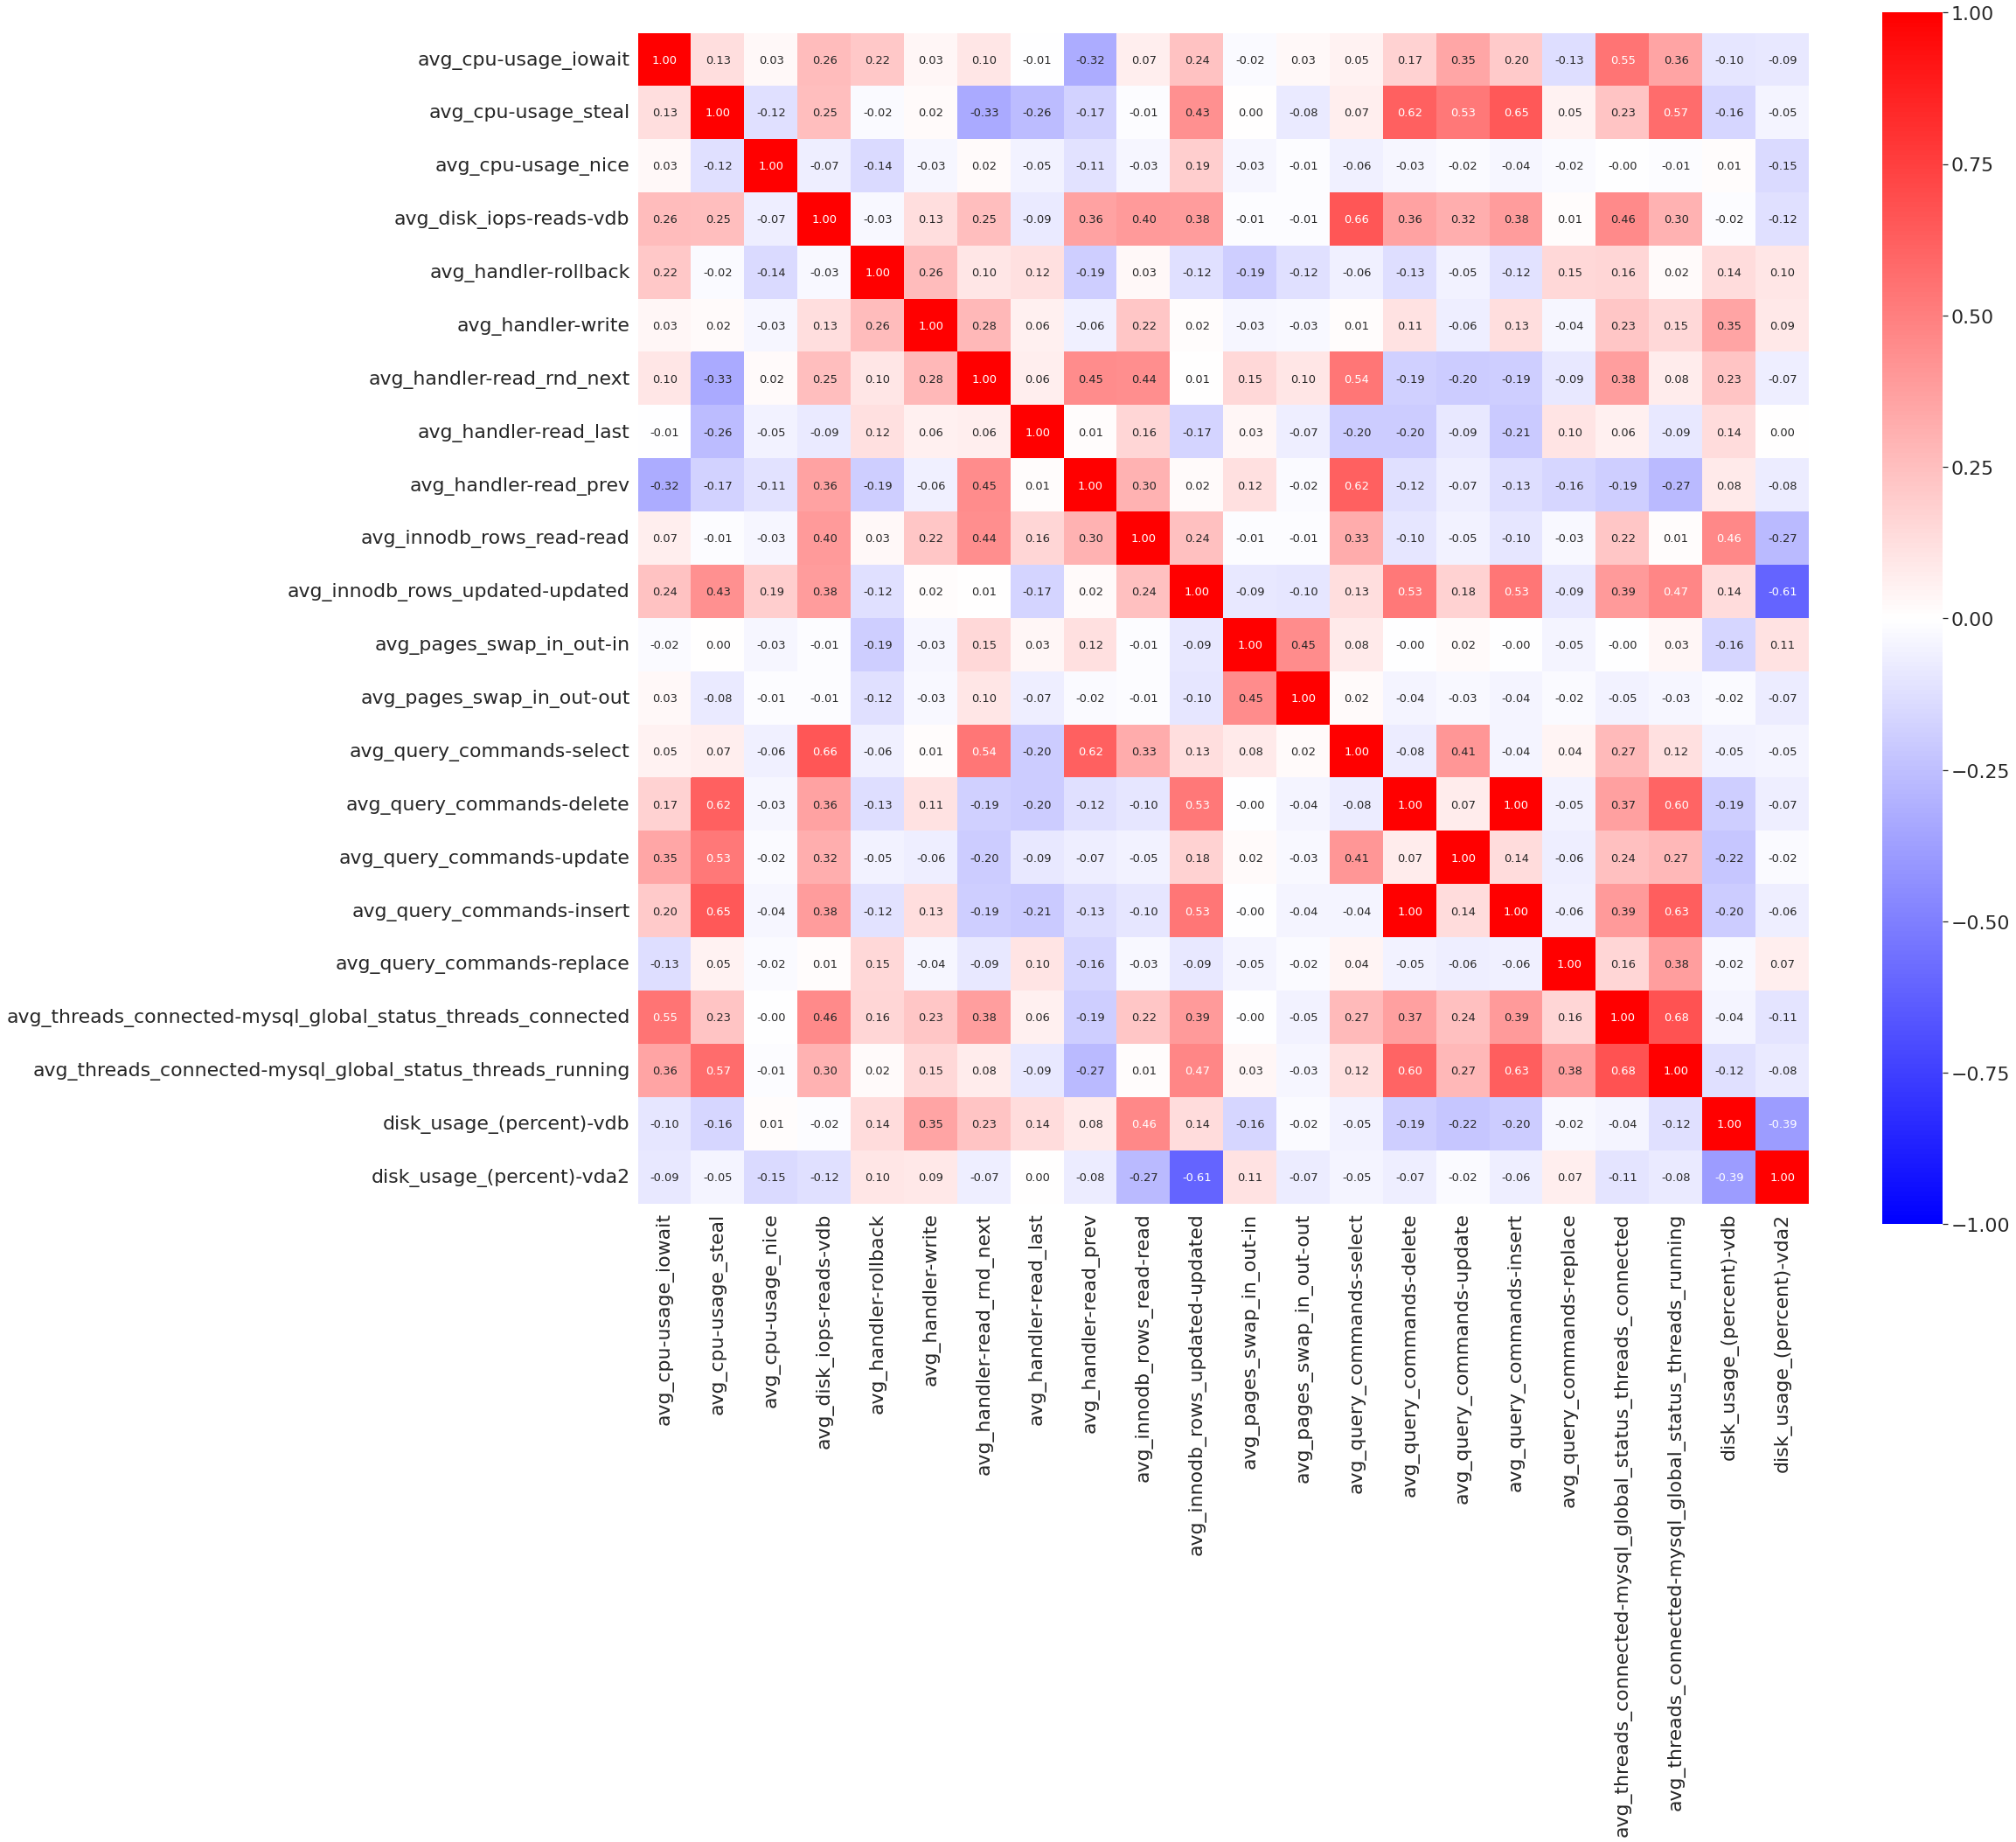

In [10]:
sns.set(font_scale=2)
plt.figure(figsize=(30, 30))
sns.heatmap(df_selected.corr(), vmax=1, vmin=-1, center=0, annot=True, square=True, cmap="bwr", annot_kws={"size": 13}, fmt=".2f", cbar_kws={"shrink": 0.85})
plt.show()